<a href="https://www.kaggle.com/code/chalseo/indicators-of-wealth-in-billionaires?scriptVersionId=158751994" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier, plot_importance
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Feature Importance: Indicators of Self-Made vs. Inherited Wealth in Bilionaires

In [2]:
df = pd.read_csv(filepath_or_buffer='/kaggle/input/billionaires-statistics-dataset/Billionaires Statistics Dataset.csv')
df.drop(['date', 'latitude_country', 'longitude_country'], inplace=True, axis=1)
df['gdp_country'] = df['gdp_country'].str.replace('$','').replace(',','', regex=True).astype(float)
df['finalWorth'] = df['finalWorth'] / 1000

print("\n", "Billionaires in the world: ", len(df))

billionaires_by_country = df.groupby(['country'])['personName'].count().sort_values(ascending=False)
print("\n", "Countries with billionaires: ", len(billionaires_by_country))
print("\n", "All Features: ", "\n", df.columns.values)


 Billionaires in the world:  2640

 Countries with billionaires:  78

 All Features:  
 ['rank' 'finalWorth' 'category' 'personName' 'age' 'country' 'city'
 'source' 'industries' 'countryOfCitizenship' 'organization' 'selfMade'
 'status' 'gender' 'birthDate' 'lastName' 'firstName' 'title' 'state'
 'residenceStateRegion' 'birthYear' 'birthMonth' 'birthDay' 'cpi_country'
 'cpi_change_country' 'gdp_country' 'gross_tertiary_education_enrollment'
 'gross_primary_education_enrollment_country' 'life_expectancy_country'
 'tax_revenue_country_country' 'total_tax_rate_country'
 'population_country']


In [3]:
print("Numerical Data Summary: ")
df.describe(include=np.number, percentiles=[]).T

Numerical Data Summary: 


,count,mean,std,min,50%,max
rank,2640.0,1.289159e+03,7.396937e+02,1.000000e+00,1.312000e+03,2.540000e+03
finalWorth,2640.0,4.623788e+00,9.834241e+00,1.000000e+00,2.300000e+00,2.110000e+02
age,2575.0,6.514019e+01,1.325810e+01,1.800000e+01,6.500000e+01,1.010000e+02
birthYear,2564.0,1.957183e+03,1.328252e+01,1.921000e+03,1.957000e+03,2.004000e+03
birthMonth,2564.0,5.740250e+00,3.710085e+00,1.000000e+00,6.000000e+00,1.200000e+01
birthDay,2564.0,1.209984e+01,9.918876e+00,1.000000e+00,1.100000e+01,3.100000e+01
cpi_country,2456.0,1.277552e+02,2.645295e+01,9.955000e+01,1.172400e+02,2.885700e+02
cpi_change_country,2456.0,4.364169e+00,3.623763e+00,-1.900000e+00,2.900000e+00,5.350000e+01
gdp_country,2476.0,1.158287e+13,9.575588e+12,3.154058e+09,1.991000e+13,2.142770e+13
gross_tertiary_education_enrollment,2458.0,6.722567e+01,2.134343e+01,4.000000e+00,6.560000e+01,1.366000e+02


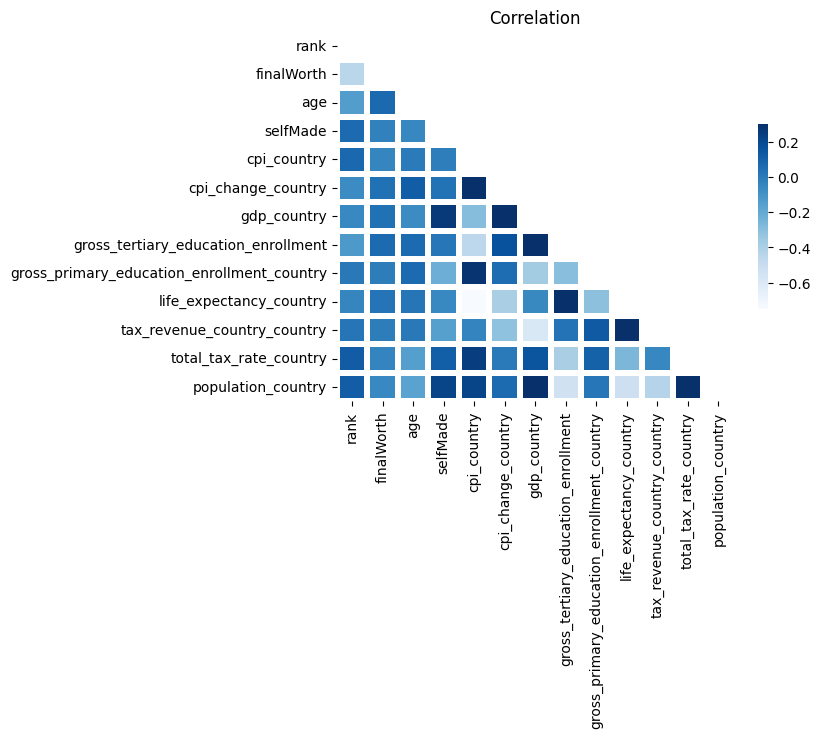

In [4]:
corr = df.drop(columns=['birthYear', 'birthMonth', 'birthDay']).corr(numeric_only=True)
sns.heatmap(corr, mask=np.triu(corr), vmax=.3, linewidths=3, cmap='Blues', cbar_kws={"shrink": .5})
plt.title("Correlation")
plt.show()

In [5]:
print("Categorical Data Summary: ")
df.describe(include='O').T

Categorical Data Summary: 


,count,unique,top,freq
category,2640,18,Finance & Investments,372
personName,2640,2638,Wang Yanqing & family,2
country,2602,78,United States,754
city,2568,741,New York,99
source,2640,906,Real estate,151
industries,2640,18,Finance & Investments,372
countryOfCitizenship,2640,77,United States,735
organization,325,294,Meta Platforms,4
status,2640,6,D,1223
gender,2640,2,M,2303


In [6]:
print("Top countries with billionaires: ", "\n", df.groupby(['country'])['personName'].count().sort_values(ascending=False)[0:10].index.values)
print("\n", "Top cities for billionaires:  ", "\n", df.groupby(['city'])['personName'].count().sort_values(ascending=False)[0:10].index.values)

Top countries with billionaires:  
 ['United States' 'China' 'India' 'Germany' 'United Kingdom' 'Russia'
 'Switzerland' 'Hong Kong' 'Italy' 'Singapore']

 Top cities for billionaires:   
 ['New York' 'Beijing' 'Hong Kong' 'Shanghai' 'London' 'Moscow' 'Mumbai'
 'Shenzhen' 'Singapore' 'Delhi']


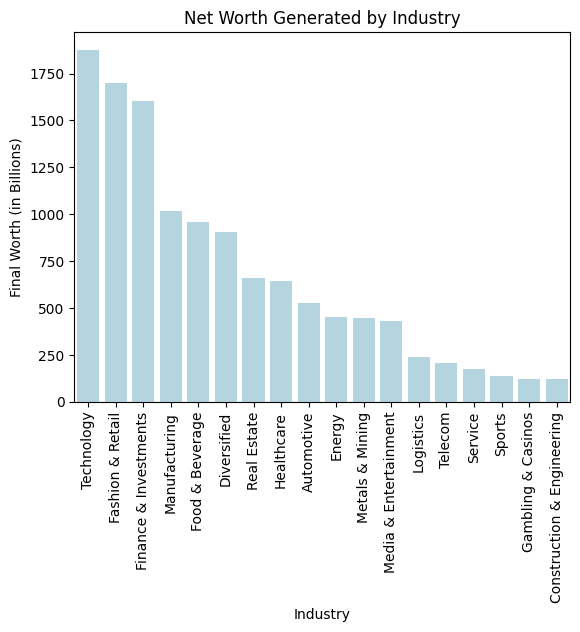

In [7]:
industry_net_worth = df.groupby(['industries'])['finalWorth'].sum()
industry_net_worth = industry_net_worth.sort_values(ascending=False)[0:20].reset_index()
sns.barplot(industry_net_worth, x='industries', y='finalWorth', color='lightblue')

plt.title("Net Worth Generated by Industry")
plt.ylabel("Final Worth (in Billions)")
plt.xlabel("Industry")
plt.xticks(rotation=90)
plt.show()

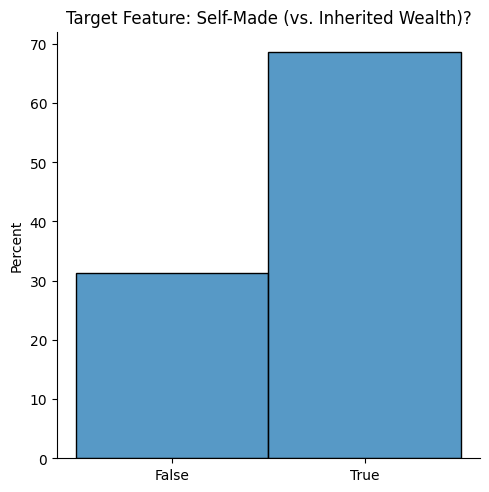

In [8]:
sns.displot(df.selfMade.astype('str'), stat='percent', legend=True)
plt.title("Target Feature: Self-Made (vs. Inherited Wealth)?")
plt.xlabel(None)
plt.show()

In [9]:
# Dropping columns not useful for analysis and/or not worth encoding in model due to similarity to another 
wealth_df = df.drop(['personName',  'firstName', 'birthDate', 'birthYear', 'birthMonth', 'birthDay',
                     'countryOfCitizenship', 'city', 'state', 'residenceStateRegion', 'status', 'category', 'organization'], axis=1)
print("Numerical Features:")
numerical_features = wealth_df.describe(include=np.number).columns.values
print(numerical_features)

print("\n", "Categorical Features:")
categorical_features = wealth_df.describe(include=['O']).columns.values
print(categorical_features)

Numerical Features:
['rank' 'finalWorth' 'age' 'cpi_country' 'cpi_change_country'
 'gdp_country' 'gross_tertiary_education_enrollment'
 'gross_primary_education_enrollment_country' 'life_expectancy_country'
 'tax_revenue_country_country' 'total_tax_rate_country'
 'population_country']

 Categorical Features:
['country' 'source' 'industries' 'gender' 'lastName' 'title']


In [10]:
# Several NaN values exist across columns - xgboost models address missing data
nan_count = df.isna().sum()
nan_count = nan_count[nan_count > 0]
print(nan_count.sort_values())

firstName                                        3
country                                         38
age                                             65
city                                            72
birthDay                                        76
birthYear                                       76
birthMonth                                      76
birthDate                                       76
gdp_country                                    164
population_country                             164
gross_primary_education_enrollment_country     181
total_tax_rate_country                         182
gross_tertiary_education_enrollment            182
life_expectancy_country                        182
tax_revenue_country_country                    183
cpi_country                                    184
cpi_change_country                             184
state                                         1887
residenceStateRegion                          1893
title                          

In [11]:
x = wealth_df.drop(columns=["selfMade"])
y = wealth_df.selfMade

# Normalize/scale data
transformer = make_column_transformer(
    (StandardScaler(), numerical_features),
    (OneHotEncoder(), categorical_features), sparse_threshold=0)
transformed_data = transformer.fit_transform(x)

feature_names = [name.split("__")[-1] for name in transformer.get_feature_names_out()]
X = pd.DataFrame(transformed_data, columns=feature_names).drop(columns=['country_nan', 'title_nan'])

print("# Features: {0}".format(len(X.columns)))

print("\nSelf made: ", len(wealth_df[wealth_df.selfMade == 1]))
print("Inherited: ", len(wealth_df[wealth_df.selfMade == 0]))

# Features: 2849

Self made:  1812
Inherited:  828


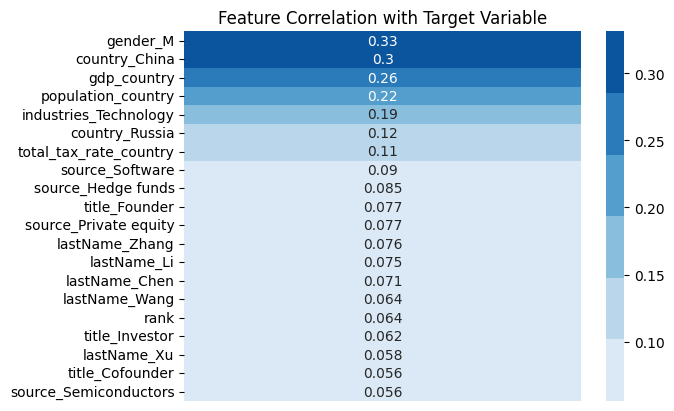

In [12]:
target_corr = pd.DataFrame(X.join(y).corrwith(y).sort_values(ascending=False))
sns.heatmap(target_corr.iloc[1:21], annot=True, xticklabels=False, cmap=sns.color_palette("Blues"))
plt.title("Feature Correlation with Target Variable")
plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print("Training set size: ", len(X_train))
print("Testing set size: ", len(X_test))

Training set size:  1768
Testing set size:  872


In [14]:
clf = XGBClassifier(objective='binary:logistic', 
                    eval_metric='auc',
                    random_state=0,
                    n_jobs=-1)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)

print("ROC AUC scores:")
print("Train: %.2f%%" % (round(roc_auc_score(y_train, y_train_pred) * 100, 2)))
print("Test: %.2f%%" % (round(roc_auc_score(y_test, y_pred) * 100, 2)))

ROC AUC scores:
Train: 95.19%
Test: 71.79%


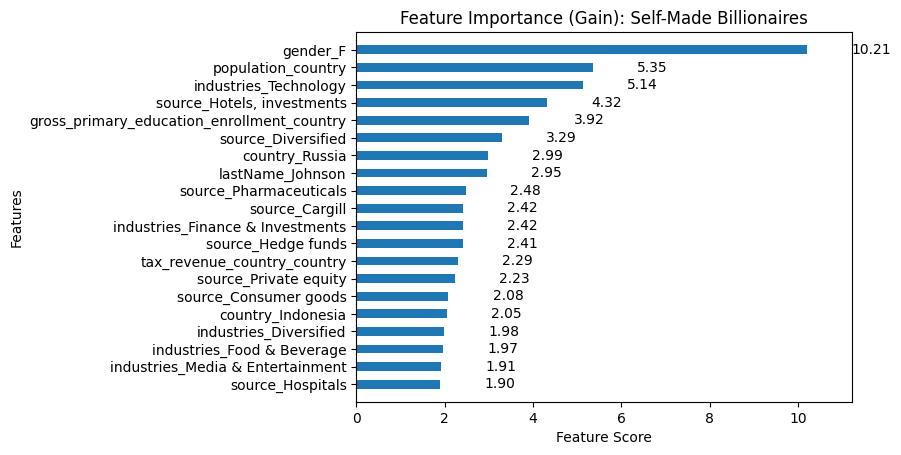

In [15]:
importances = clf.get_booster().get_score(importance_type='gain')
plot_importance(importances, max_num_features=20, grid=False, height=.5,
                title="Feature Importance (Gain): Self-Made Billionaires", values_format="{v:.2f}")
plt.xlabel("Feature Score")
plt.show()

In [16]:
self_made = wealth_df.selfMade.value_counts()
rs_params = {
 "learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree": [ 0.3, 0.4, 0.5 , 0.7 ],
 "scale_pos_weight": [self_made[0]/self_made[1]] 
}

rs_clf = RandomizedSearchCV(estimator=clf, 
                            scoring='roc_auc', 
                            param_distributions=rs_params, 
                            random_state=0,
                            n_jobs=-1,
                            cv=10)
rs_clf.fit(X_train, y_train)

print("Best set of hyperparameters: ", "\n", rs_clf.best_params_)
print("AUC-ROC score: %.2f%%" % round(rs_clf.best_score_ * 100, 2))

Best set of hyperparameters:  
 {'scale_pos_weight': 2.1884057971014492, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.5}
AUC-ROC score: 84.48%


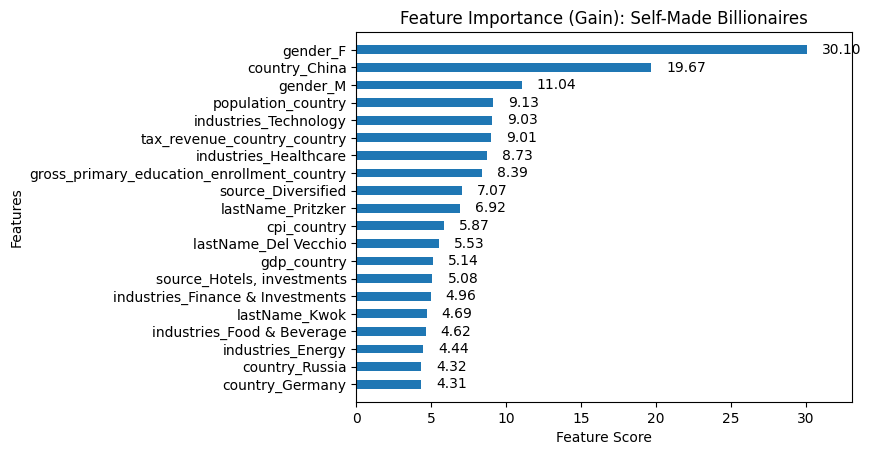

In [17]:
rs_importances = rs_clf.best_estimator_.get_booster().get_score(importance_type='gain')
plot_importance(rs_importances, max_num_features=20, grid=False, height=.5,
                title="Feature Importance (Gain): Self-Made Billionaires", values_format="{v:.2f}")
plt.xlabel("Feature Score")
plt.show()

<!-- https://www.aitimejournal.com/intro-to-classification-and-feature-selection-with-xgboost/2778/ -->

In [18]:
# Compare features across each stage of analysis 
corr_with_target = target_corr[1:21].index.values
feat_importance = pd.Series(importances).sort_values(ascending=False).iloc[0:20].index.values
feat_importance_rs_cv = pd.Series(rs_importances).sort_values(ascending=False).iloc[0:20].index.values

ranking_df  = pd.DataFrame(data=[corr_with_target, feat_importance, feat_importance_rs_cv], 
                           index=["Correlation with Target", "Feature Importance", "Feature Importance (with CV)"]).T
ranking_df.index.name = "Ranking"
ranking_df.index += 1 
ranking_df

,Correlation with Target,Feature Importance,Feature Importance (with CV)
Ranking,,,
1,gender_M,gender_F,gender_F
2,country_China,population_country,country_China
3,gdp_country,industries_Technology,gender_M
4,population_country,"source_Hotels, investments",population_country
5,industries_Technology,gross_primary_education_enrollment_country,industries_Technology
6,country_Russia,source_Diversified,tax_revenue_country_country
7,total_tax_rate_country,country_Russia,industries_Healthcare
8,source_Software,lastName_Johnson,gross_primary_education_enrollment_country
9,source_Hedge funds,source_Pharmaceuticals,source_Diversified
